In [1]:
from comet_ml import Experiment
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

load_dotenv('../.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question5/XGboost_FeaturesSelection')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibrationDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import seaborn as sn
from matplotlib.pyplot import figure
from sklearn import linear_model
from sklearn import feature_selection 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/52a03f7acdad4b4eb24ed265988482df



In [2]:
# Read and preprocess data
df = pd.read_csv('../data/trainingSet.csv')

#df = df.rename({'Goal': 'is_goal'}, axis=1)
#df = df[~(df['is_goal'].isnull() | df['distanceFromNet'].isnull() | df['angle'].isnull())] #remove after fix
#df['is_goal'] = df['is_goal'].astype(np.int64)

#df=pd.read_csv('../data/trainingSet.csv')


df['rebound']=df['rebound'].astype(int)

FinalDf = df[['gameSeconds','period','xCoord','yCoord','distanceFromNet','angle','shotType','lastEventType', 'lastEventXCoord',
       'lastEventYCoord','lastEventGameSeconds','distanceFromLastEvent','rebound', 
       'changeInAngleShot', 'speed','Goal']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()



FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)

#Frame is the dataset used fpr xgboost later
Frame=pd.concat([FinalDf,obj_df],axis=1)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(FinalDf)
Transformed_Values=imp_mean.transform(FinalDf)
TransformedDf = pd.DataFrame(Transformed_Values, index=df.index, columns=FinalDf.columns)
X = TransformedDf.drop('Goal',axis=1)
y = TransformedDf['Goal'].to_numpy()


####  Split the data , this split is performed only once (same events will be used as train/test for each model) 

In [3]:
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates



In [17]:
### 
def displayFigures(Models,X_train,Y_train,X_val,Y_val,Text_label,X_trainAll=X_train,Y_trainAll=y_train,X_valAll=x_val,Y_valAll=y_val):
    
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    #RandomClassifier
    random_clf = DummyClassifier(strategy="uniform").fit(X_trainAll, Y_trainAll)

    train_score2 = random_clf.score(X_trainAll, Y_trainAll)
    val_score2 = random_clf.score(X_valAll, Y_valAll)

    print(f'Training accuracy: {train_score2}')
    print(f'Validation accuracy: {val_score2}')
    
    random_probs = random_clf.predict_proba(X_valAll.to_numpy().reshape(-1, len(X_valAll.columns))[:, :])[:,1]

    random_auc = roc_auc_score(Y_valAll, random_probs)

    print('Random: ROC AUC=%.3f' % (random_auc))


    random_fpr, random_tpr, _ = roc_curve(Y_valAll, random_probs)
    axs[0, 0].plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')
    axs[0, 0].set_xlabel('False Positive Rate')
    axs[0, 0].set_ylabel('True Positive Rate')
    axs[0, 0].legend()
    
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, Y_valAll)
    axs[0, 1].plot(percentiles2, rates2, marker='.', label='Random')
    axs[0, 1].set_xlabel('Shot probability model percentile')
    axs[0, 1].set_ylabel('Goal rate')
    axs[0, 1].legend()
    
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, Y_valAll)
    axs[1, 0].plot(percentiles2, rates2, marker='.', label='Random')
    axs[1, 0].set_xlabel('Shot probability model percentile')
    axs[1, 0].set_ylabel('Goal rate')
    axs[1, 0].legend()  
    
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_valAll, Y_valAll, label='Random', ax=axs[1, 1])

    for idx, Model in enumerate(Models):
        print(Text_label[idx])
        xgb_probs = Model.predict_proba(X_val[idx][:, :])[:,1]
        xgb_auc = roc_auc_score(Y_val[0], xgb_probs)

        print(Text_label[idx]+': ROC AUC=%.3f' % (xgb_auc))

        xgb_fpr1, xgb_tpr1, _ = roc_curve(Y_val[0], xgb_probs)


        axs[0, 0].plot(xgb_fpr1, xgb_tpr1, marker='.', label=Text_label[idx])


        percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs, Y_val[0])


        axs[0, 1].plot(percentiles1, rates1, marker='.', label=Text_label[idx])

        percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs, Y_val[0])


        axs[1, 0].plot(percentiles1, rates1, marker='.', label=Text_label[idx])
        
        disp1 = CalibrationDisplay.from_estimator(Model, X_val[idx], Y_val[0], label=Text_label[idx], ax=axs[1, 1])

    # plt.savefig('../figures/calibration_diagram.png')

    #plt.show()
def plot_ConfusionMatrix(y_pred,y_test):
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

### Question-1:

COMET WARNING: You must install graphviz to plot tree


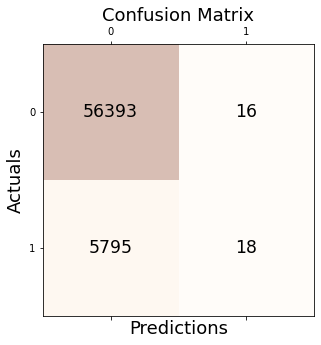

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     56409
         1.0       0.53      0.00      0.01      5813

    accuracy                           0.91     62222
   macro avg       0.72      0.50      0.48     62222
weighted avg       0.87      0.91      0.86     62222

Training accuracy: 0.9062294080776586
Validation accuracy: 0.9066085950306966


In [6]:
### XGBoost on distance+angle ###

X_train_1 = X_train[['distanceFromNet', 'angle']].to_numpy().reshape(-1, 2)
X_val_1 = x_val[['distanceFromNet', 'angle']].to_numpy().reshape(-1, 2)

xgb_clf_Distance_Angle = XGBClassifier().fit(X_train_1, y_train)


train_score1 = xgb_clf_Distance_Angle.score(X_train_1, y_train)
val_score1 = xgb_clf_Distance_Angle.score(X_val_1, y_val)
preds_Val = xgb_clf_Distance_Angle.predict(X_val_1)
plot_ConfusionMatrix(preds_Val,y_val)
print(classification_report(y_val, preds_Val))
print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')


### Question-2: 
Game seconds-
Game period-
Coordinates (x,y, separate columns)-
Shot distance-
Shot angle-
Shot type-

Last event type-
Coordinates of the last event (x, y, separate columns)-
Time from the last event (seconds)-
Distance from the last event-
Rebound (bool): -
Change in shot angle-
“Speed”-

### XGBoost using all features only encoding  (no feature selection) 

Training accuracy: 0.9100866267015959
Validation accuracy: 0.9068818102921796


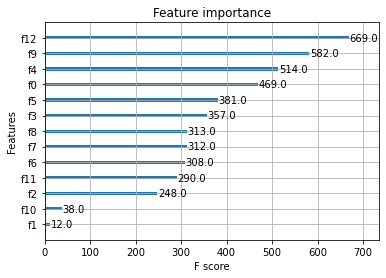

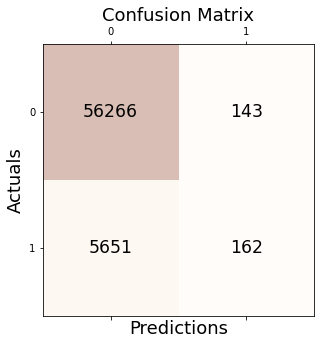

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     56409
         1.0       0.53      0.03      0.05      5813

    accuracy                           0.91     62222
   macro avg       0.72      0.51      0.50     62222
weighted avg       0.87      0.91      0.87     62222



In [8]:
### XGBoost using all features  ###
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint



X_train1XG_All = X_train.to_numpy().reshape(-1, len(X_train.columns))
X_val1XG_All = x_val.to_numpy().reshape(-1, len(X_train.columns))

xgb_clf = XGBClassifier().fit(X_train1XG_All, y_train)


plot_importance(xgb_clf)


train_score1 = xgb_clf.score(X_train1XG_All, y_train)
val_score1 = xgb_clf.score(X_val1XG_All, y_val)


print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
preds_Val = xgb_clf.predict(X_val1XG_All)
plot_ConfusionMatrix(preds_Val,y_val)
print(classification_report(y_val, preds_Val))
#displayFigures(xgb_clf,X_train1XG_All,y_train,X_val1XG_All,y_val,"XGBOOST_AllFeatures")

In [9]:
exp.log_metrics({'Training accuracy': train_score1, 'Validation accuracy': val_score1})

### Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [10]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
print(shap.__version__)

AttributeError: module 'shap' has no attribute 'Explainer'

Training accuracy: 0.9068361164237154
Validation accuracy: 0.9064639516569702


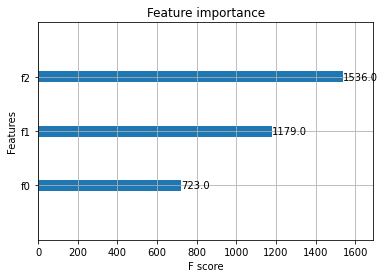

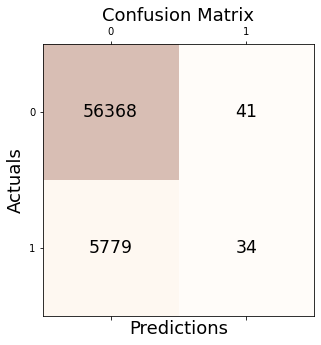

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     56409
         1.0       0.45      0.01      0.01      5813

    accuracy                           0.91     62222
   macro avg       0.68      0.50      0.48     62222
weighted avg       0.86      0.91      0.86     62222



In [11]:
#### Run XGboost with features that are pushing the prediction higher with xgboost:
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint


X_trainXG_SHAP_=X_train[['changeInAngleShot','gameSeconds','speed']]
X_valXG_SHAP=x_val[['changeInAngleShot','gameSeconds','speed']]

X_trainXG_SHAP = X_trainXG_SHAP_.to_numpy().reshape(-1, len(X_trainXG_SHAP_.columns))
X_val1XG_SHAP = X_valXG_SHAP.to_numpy().reshape(-1, len(X_trainXG_SHAP_.columns))

xgb_cl_SHAP = XGBClassifier().fit(X_trainXG_SHAP, y_train)


plot_importance(xgb_cl_SHAP)


train_score1 = xgb_cl_SHAP.score(X_trainXG_SHAP, y_train)
val_score1 = xgb_cl_SHAP.score(X_val1XG_SHAP, y_val)


print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
preds_Val = xgb_cl_SHAP.predict(X_val1XG_SHAP)
plot_ConfusionMatrix(preds_Val,y_val)
print(classification_report(y_val, preds_Val))
#exp.log_metrics({'Training accuracy': train_score1, 'Validation accuracy': val_score1})
#displayFigures(xgb_cl_SHAP,X_trainXG_SHAP_,y_train,X_val1XG_SHAP,y_val,"XGBOOST_selectedFeatures_SHAP")

## Analyzing correlation between:  
**features to features (redundancy identification) 
**features to target (relevance identification)

In [12]:
### should run previous part to have Frame
df_f = Frame.dropna()

X = df_f.drop('Goal',axis=1)
y = df_f['Goal'].to_numpy()
df_f.shape

(55365, 16)

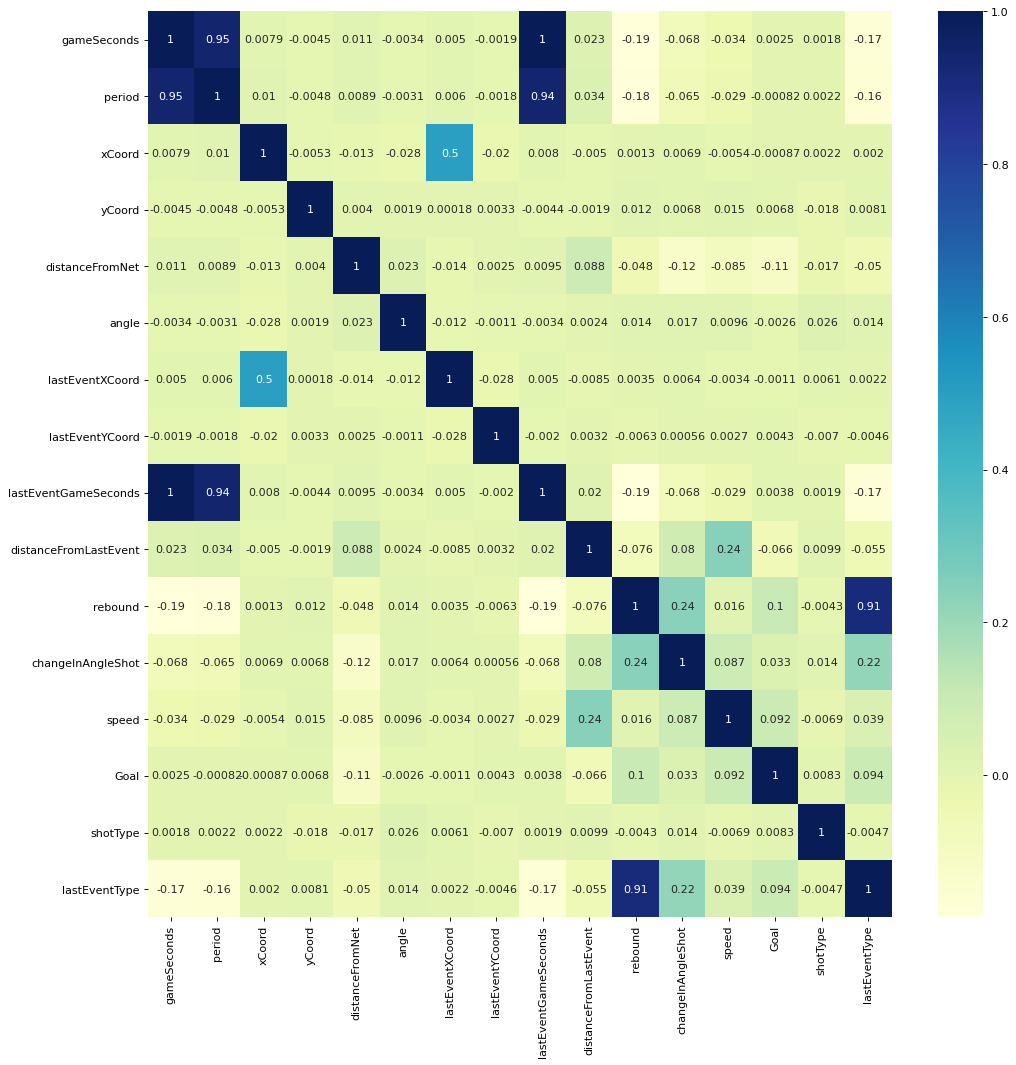

In [13]:
corrMatrix = df_f.corr()

figure(figsize=(15, 15), dpi=80)
sn.heatmap(corrMatrix, annot=True,cmap="YlGnBu")
plt.show()
#plt.savefig('../figures/correlation.png')

## Lasso

In [14]:
clf = linear_model.Lasso(alpha=0.1)
selector = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train,y_train)
selected_feature_indices = np.where(selector._get_support_mask())[0] 
res_list = [X_train.columns[i] for i in selected_feature_indices] 
res_list

['distanceFromNet', 'speed']

### XGBoost classifier using selected featurs by Lasso:

Training accuracy: 0.9067115604056508
Validation accuracy: 0.9063675227411526


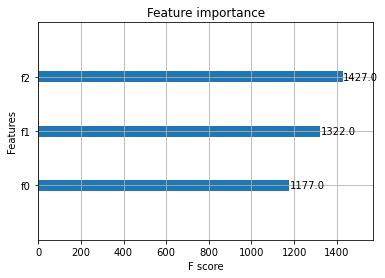

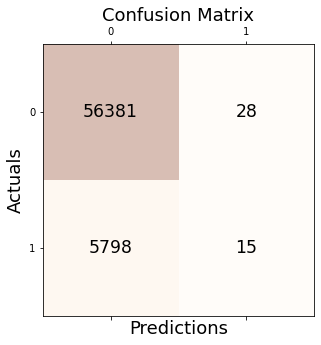

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     56409
         1.0       0.35      0.00      0.01      5813

    accuracy                           0.91     62222
   macro avg       0.63      0.50      0.48     62222
weighted avg       0.85      0.91      0.86     62222



In [15]:
### XGBoost using all features  ###
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint

X_trainXG_select=X_train[['distanceFromNet','distanceFromLastEvent','speed']]
X_valXG_select=x_val[['distanceFromNet','distanceFromLastEvent','speed']]



X_train1XG_select = X_trainXG_select.to_numpy().reshape(-1, len(X_trainXG_select.columns))
X_val1XG_select = X_valXG_select.to_numpy().reshape(-1, len(X_trainXG_select.columns))

xgb_clf_select = XGBClassifier().fit(X_train1XG_select, y_train)


plot_importance(xgb_clf_select)


train_score1 = xgb_clf_select.score(X_train1XG_select, y_train)
val_score1 = xgb_clf_select.score(X_val1XG_select, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
preds_Val = xgb_clf_select.predict(X_val1XG_select)
plot_ConfusionMatrix(preds_Val,y_val)
print(classification_report(y_val, preds_Val))
#displayFigures(xgb_clf_select,X_train1XG_select,y_trainXG_select,X_val1XG_select,y_valXG_select,"XGBOOST_selectedFeatures_Lasso")

Training accuracy: 0.5011290400347149
Validation accuracy: 0.5013178618495066
Random: ROC AUC=0.500
XGBOOST_AllFeatures
XGBOOST_AllFeatures: ROC AUC=0.754
xgb_cl_SHAP
xgb_cl_SHAP: ROC AUC=0.598
LassoSelection
LassoSelection: ROC AUC=0.711
Distance_Angle_Only
Distance_Angle_Only: ROC AUC=0.716


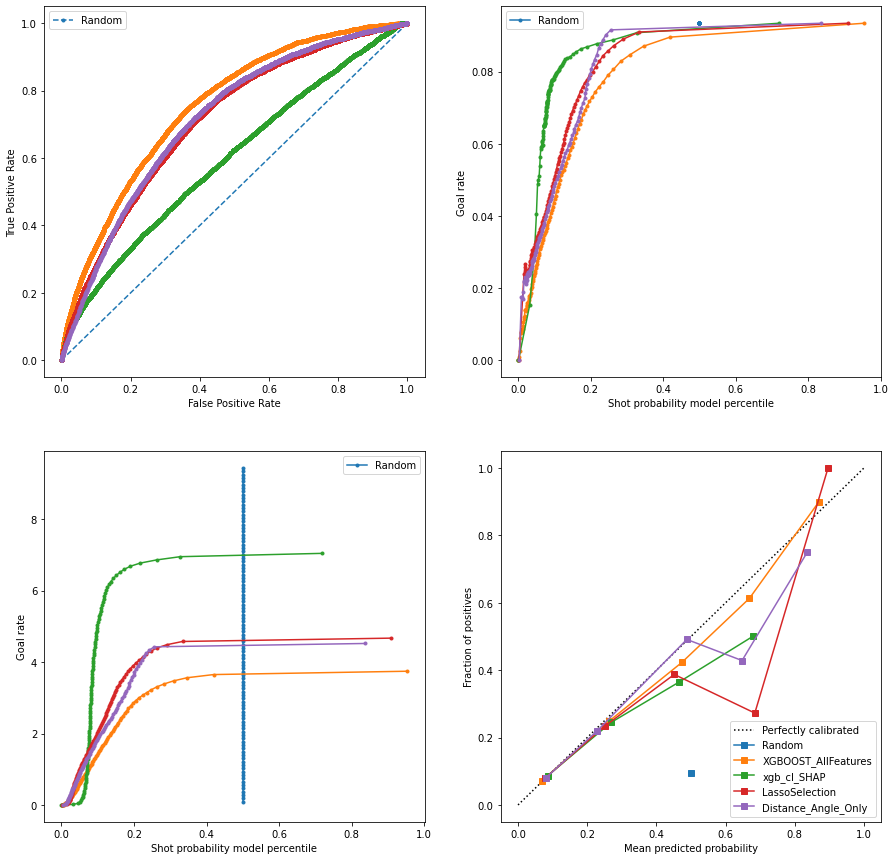

In [19]:
displayFigures([xgb_clf,xgb_cl_SHAP,xgb_clf_select,xgb_clf_Distance_Angle],[X_train1XG_All,X_trainXG_SHAP_,X_train1XG_select,X_train_1],[y_train],[X_val1XG_All,X_val1XG_SHAP,X_val1XG_select,X_val_1],[y_val],["XGBOOST_AllFeatures","xgb_cl_SHAP","LassoSelection","Distance_Angle_Only"])


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', XGBClassifier())
])
clf.fit(X_train, y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
train_score = clf.score(X_train, y_train)
plot_ConfusionMatrix(predictions,y_val)
print(classification_report(y_val, preds_Val))
print("Training Accuracy: %.1f%%" % ( train_score*100.0))
print(f'Validation accuracy: {accuracy*100.0}')
print("ROC AUC : ", roc_auc_score(y_val, predictions))

### Feature Selection using Wrapper methods

In [ ]:
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
        #train
    accuracyTrain= selection_model.score(select_X_train, y_train)
        #validation
    select_X_test = selection.transform(x_val)
    predictions = selection_model.predict(select_X_test)
    accuracyValidation = accuracy_score(y_val, predictions)
    print("Thresh=%.3f, n=%d, accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracyTrain*100.0))
    print("Thresh=%.3f, n=%d, Validation: %.2f%%" % (thresh, select_X_train.shape[1], accuracyValidation*100.0))
    print("ROC AUC : ", roc_auc_score(y_val, predictions))
    